In [1]:
#standard
import os
import pickle

#third party
import numpy as np
import hcp_utils as hcp
import matplotlib.pyplot as plt
from nilearn import plotting

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
def calculate_noiseceiling(betas, n: int=1):
    """
    Code adapted from GLMsingle example: https://github.com/cvnlab/GLMsingle/blob/main/examples/example9_noiseceiling.ipynb
    Computes the noiseceiling at every vertex on a 2D surface.
    Parameters:
    betas: beta estimates in shape (vertices, num_reps, num_stimuli)
    n: number of trials you average over for the noiseceiling. default is 1 for single trial noiseceiling
    Returns:
    ncsnr: noise-ceiling SNR at each voxel in shape (voxel_x, voxel_y, voxel_z) as ratio between signal std and noise std
    noiseceiling: noise ceiling at each voxel in shape (voxel_x, voxel_y, voxel_z) as % of explainable variance 
    Code adapted from GLMsingle example: https://github.com/cvnlab/GLMsingle/blob/main/examples/example9_noiseceiling.ipynb
    """
    assert(len(betas.shape) == 3)
    numvertices = betas.shape[0]
    num_reps = betas.shape[1]
    num_vids = betas.shape[2]
    noisesd = np.sqrt(np.mean(np.power(np.std(betas,axis=1,keepdims=1,ddof=1),2),axis=2)).reshape((numvertices,))

    # Calculate the total variance of the single-trial betas.
    totalvar = np.power(np.std(np.reshape(betas, (numvertices , num_reps*num_vids)), axis=1),2)

    # Estimate the signal variance and positively rectify.
    signalvar = totalvar - np.power(noisesd,2)

    signalvar[signalvar < 0] = 0
    # Compute ncsnr as the ratio between signal standard deviation and noise standard deviation.
    ncsnr = np.sqrt(signalvar) / noisesd

    # Compute noise ceiling in units of percentage of explainable variance
    noiseceiling = 100 * (np.power(ncsnr,2) / (np.power(ncsnr,2) + 1/n))
    return ncsnr, noiseceiling

In [15]:
#define subject and task
subject="sub-01" #'sub-01' through 'sub-10'
task = "test" #'train' or 'test'

#setup paths
project_root = "/data/vision/oliva/scratch/blahner/BMD_tmp" #os.path.join("/your","local","project","path")
fmri_path = os.path.join(project_root, "betas-prepared", "step01") #os.path.join(project_root,"derivatives","versionB","ciftify","GLMsingle",subject, "betas_prepared", "step01")

In [16]:
#load the beta estimates. z=1 means the betas have been z-scored across conditions, z=0 means they have not
with open(os.path.join(fmri_path, f"{subject}_z=0_GLMsingle_type-typed_task-{task}.pkl"), 'rb') as f:
    betas = pickle.load(f)
print(f"betas.shape (numvertices, numreps, numstimuli): {betas.shape}")

betas.shape (numvertices, numreps, numstimuli): (91282, 3, 1000)


In [19]:
ncsnr, noiseceiling = calculate_noiseceiling(betas, n=1)
print(np.nanmax(noiseceiling))

60.771694047156444


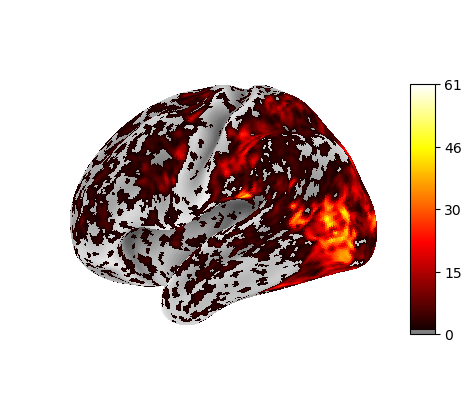

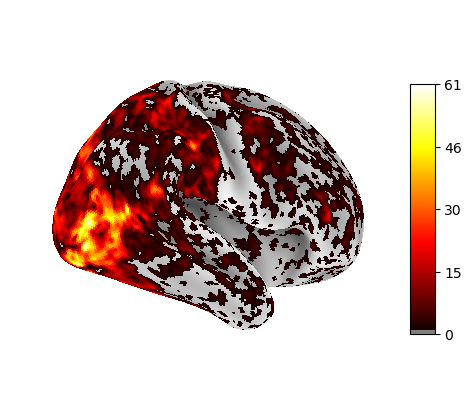

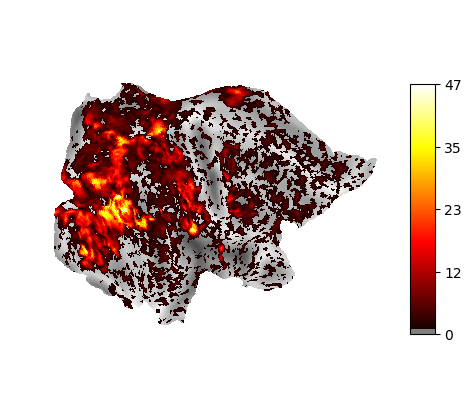

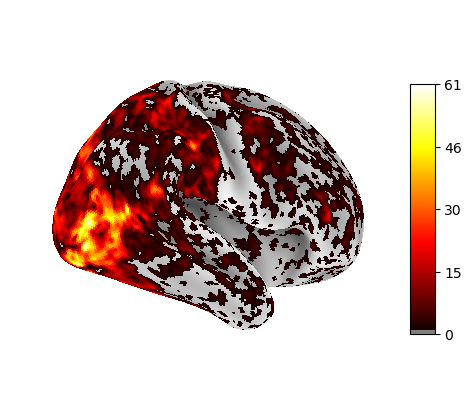

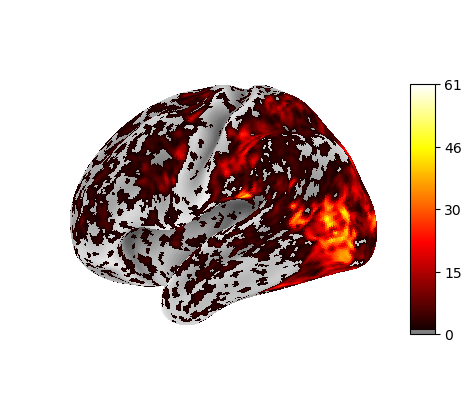

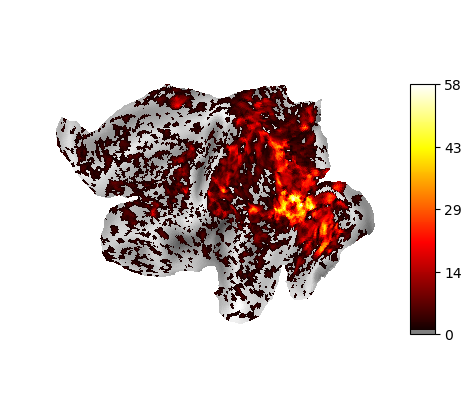

In [20]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
noiseceiling[noiseceiling < 0] = 0
stat = noiseceiling.copy()
for hemi in ['left','right']:
    mesh = hcp.mesh.inflated
    cortex_data = hcp.cortex_data(stat)
    bg = hcp.mesh.sulc
    #inflated brain
    for view in views:
        display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
        threshold=1, bg_map=hcp.mesh.sulc, view=view, cmap='hot')
        plt.show()

    if hemi == 'left':
        cortex_data = hcp.left_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
        threshold=1, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot')
        plt.show()

    if hemi == 'right':
        cortex_data = hcp.right_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
        threshold=1, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot')
        plt.show()